# Image segmentation using U-Net
References:
- [Guide](https://medium.com/@alessandromondin/semantic-segmentation-with-pytorch-u-net-from-scratch-502d6565910a)
- [Handling COCO dataset](https://www.kaggle.com/code/armanasgharpoor1993/coco-dataset-tutorial-image-segmentation)

In [12]:
# Import necessary libraries
import numpy as np
import os, sys 
import matplotlib.pyplot as plt
import fiftyone as fo 
import fiftyone.zoo as foz
from collections import defaultdict
from coco_dataloader import COCODataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T

In [13]:
# Load dataset

# Save to current directory
curr_dir = os.getcwd()
fo.config.dataset_zoo_dir = curr_dir 

# Download the data 
dataset = foz.load_zoo_dataset("coco-2017",
                            splits=['train'],
                            shuffle=True,
                            label_type=['segmentations'],
                            classes=['person', 'cat', 'car'])

Found annotations at '/Users/sudhansh/Desktop/Projects/Machine Learning Practice/Segmentation U-Net/coco-2017/raw/instances_train2017.json'
50 images found; downloading the remaining 50
 100% |████████████████████| 50/50 [4.4s elapsed, 0s remaining, 13.5 images/s]      
Writing annotations for 100 downloaded samples to '/Users/sudhansh/Desktop/Projects/Machine Learning Practice/Segmentation U-Net/coco-2017/train/labels.json'
Dataset info written to '/Users/sudhansh/Desktop/Projects/Machine Learning Practice/Segmentation U-Net/coco-2017/info.json'
Ignoring unsupported parameter 'label_type' for importer type <class 'fiftyone.utils.coco.COCODetectionDatasetImporter'>
Loading 'coco-2017' split 'train'
 100% |█████████████████| 100/100 [292.5ms elapsed, 0s remaining, 341.9 samples/s]     
Dataset 'coco-2017-train-100' created


In [14]:
dataDir='./coco-2017/'
dataType='train2017'
annFile='{}raw/instances_{}.json'.format(dataDir,b dataType)
imageDir = '{}train/data/'.format(dataDir)
filter_classes = ['person', 'cat', 'car']


# Define transformations
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

class pairTransform(torch.nn.Module):
    def __init__(self, transforms):
       super().__init__()
       self.transforms = transforms

    def __call__(self, imgs):
        return [self.transforms(img) for img in imgs]

pairTransformo = pairTransform(transform)

# Initialize the COCO api for instance annotations
coco_dataset = COCODataset(imageDir, annFile, filter_classes, pairTransformo)


loading annotations into memory...
Done (t=10.27s)
creating index...
index created!


In [15]:
# Load the model
from classes_succinct import UNet 

batch_size = 16
learning_rate = 1e-4
num_epochs = 10
device = 'mps'
n_down = 4
input_channels = 3
first_out_channels = 4 
output_classes = 4

data_loader = DataLoader(coco_dataset, batch_size=batch_size, shuffle=True)

# 4 classes output - person, cat, car, background
model = UNet(input_channels, first_out_channels, output_classes, n_down)

# Define loss function
criterion = nn.CrossEntropyLoss()  # You can change to Dice Loss or other appropriate loss

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


UNet(
  (model): UNetBlock(
    (model): Sequential(
      (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): UNetBlock(
        (model): Sequential(
          (0): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): UNetBlock(
            (model): Sequential(
              (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
              (3): UNetBlock(
                (model): Sequential(
                  (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
                  (1): BatchNorm2d(32, eps=1e-05, momentum

In [17]:
# Training
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in data_loader:
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        flattened_output = outputs.reshape([-1, output_classes])
        flattened_masks = masks.reshape([-1]).long()
        loss = criterion(flattened_output, flattened_masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(coco_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/10], Loss: 1.3870
Epoch [2/10], Loss: 1.3869
Epoch [3/10], Loss: 1.3869
Epoch [4/10], Loss: 1.3869
Epoch [5/10], Loss: 1.3869
Epoch [6/10], Loss: 1.3869
Epoch [7/10], Loss: 1.3868
Epoch [8/10], Loss: 1.3868
Epoch [9/10], Loss: 1.3868
Epoch [10/10], Loss: 1.3868


In [43]:
print(images.shape)
image = images[0, ...].permute([1, 2, 0])
print(masks.shape)
mask = masks[0, ...].reshape(256, 256)
_, output = torch.max(outputs, dim = 1)
gimage = image[:, :, 0] * 0.2989 + image[:, :, 1] * 0.5870 + image[:, :, 2] * 0.1140
output = output[0, ...].reshape(256, 256)
print(gimage.shape, mask.shape, output.shape)

torch.Size([6, 3, 256, 256])
torch.Size([6, 1, 256, 256])
torch.Size([256, 256]) torch.Size([256, 256]) torch.Size([256, 256])


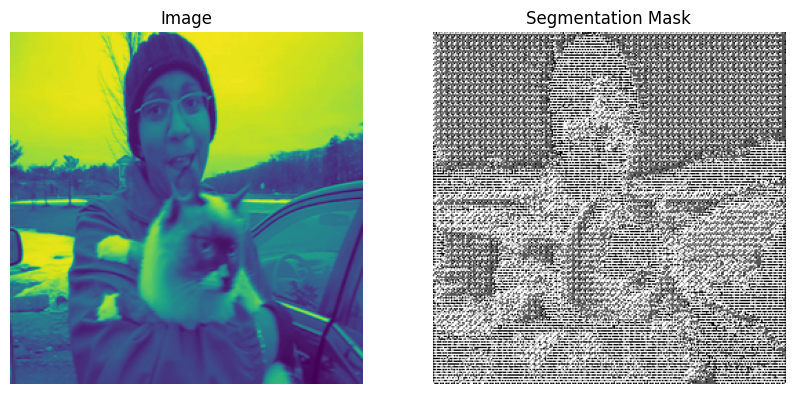

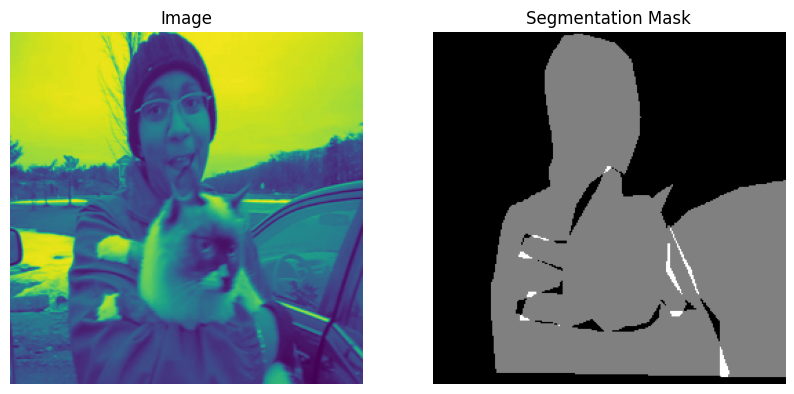

In [42]:
def visualize_segmentation(image, mask, classes=None):
    """
    Visualizes an image and its corresponding segmentation mask.
    
    Parameters:
        image (numpy.ndarray): Input image.
        mask (numpy.ndarray): Segmentation mask.
        classes (list): List of class labels. If provided, the mask will be color-coded accordingly.
    """
    plt.figure(figsize=(10, 5))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Plot the segmentation mask
    plt.subplot(1, 2, 2)
    if classes:
        colored_mask = np.zeros_like(mask, dtype=np.uint8)
        for i, label in enumerate(classes):
            colored_mask[mask == i] = label
        plt.imshow(colored_mask)
        plt.title('Segmentation Mask (Color-coded)')
    else:
        plt.imshow(mask, cmap='gray')
        plt.title('Segmentation Mask')
    plt.axis('off')

    plt.show()

# Visualize the image and mask
visualize_segmentation(gimage, output)
visualize_segmentation(gimage, mask)